# TP LEARN 

## NMF for Audio Source Separation

Mathieu Lagrange

reports are to be sent to [mathieu dot lagrange at ec-nantes dot fr] no later than a week after the lab


In [1]:
# deal with matrices
import numpy as np

# deal with audio data
import librosa as lr
from librosa import display

# handle display
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

# show loop progress
from tqdm.notebook import tqdm

# play audio
import IPython.display as ipd

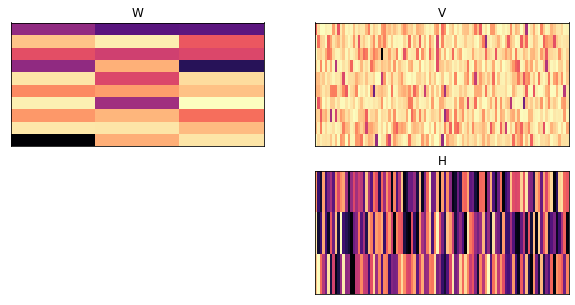

In [2]:
# utility function to display the decomposition of V into a product of W (dictionary) and H (activations)
def plotNmf(V, W, H):
    fig, axes = plt.subplots(2, 2)
    axes[1, 0].axis('off')
    lr.display.specshow(lr.amplitude_to_db(W), ax=axes[0, 0])
    lr.display.specshow(lr.amplitude_to_db(V), ax=axes[0, 1])
    lr.display.specshow(H, ax=axes[1, 1])
    axes[1, 1].sharex(axes[0, 1])
    axes[0, 0].set_title('W')
    axes[0, 1].set_title('V')
    axes[1, 1].set_title('H')
    
    plt.show()
    
plotNmf(np.random.rand(10, 100), np.random.rand(10, 3), np.random.rand(3, 100))

## NMF

Question: Implement the euclidean NMF algorithm using multiplicative update rules (see https://en.wikipedia.org/wiki/Non-negative_matrix_factorization section Algorithms). If W or H are given as parameters, they should not be updated during the optimization.

  0%|          | 0/100 [00:00<?, ?it/s]

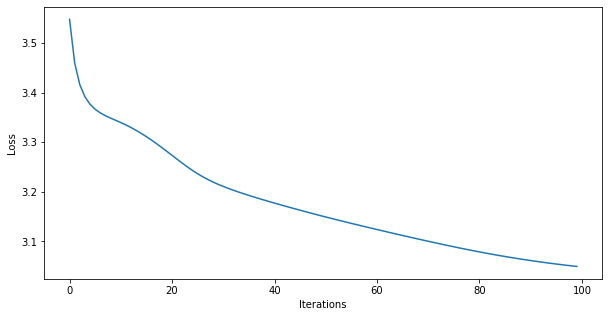

In [3]:
def nmf(V, R, L=100, W=None, H=None):
    K = V.shape[0]
    N = V.shape[1]
    w_fixed = False
    h_fixed = False
    if W is None:
        W = np.random.rand(K, R)
    else:
        w_fixed = True
    if H is None:
        H = np.random.rand(R, N)
    else:
        h_fixed = True
        
    eps_machine = np.finfo(np.float32).eps
    err = np.zeros((L))
    for it in tqdm(range(L)):
        # answer here
        if not h_fixed:
            H *= (W.T @ V / (W.T @ W @ H))
        if not w_fixed:
            W *= (V @ H.T / (W @ H @ H.T))
        #####
        V_approx = W.dot(H)
        err[it] = np.linalg.norm(V-V_approx, ord=2)
    return W, H, err

# check performance on random matrix
W, H, err = nmf(np.abs(np.random.random((10, 100))), 5)
plt.plot(err)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

## Load monophonic audio

In [4]:
drumFileName = 'sounds/drums.wav'
d, sr = lr.load(drumFileName)

ipd.Audio(d, rate=sr)

## Spectral analysis / synthesis

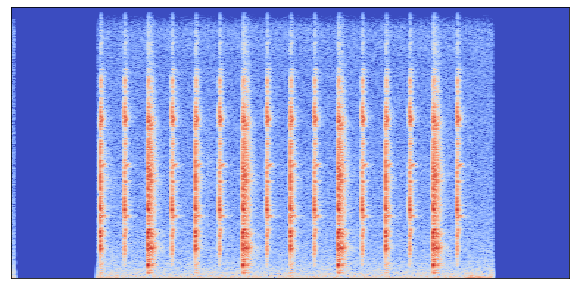

In [5]:
# short term Fourier transform (complex data)
D = lr.stft(d)
# magnitude spectrum (spectrogram)
mD = np.abs(D)
# phase spectrum
aD = np.angle(D)

# display the spectrogram in deciBels
lr.display.specshow(lr.amplitude_to_db(mD))

# synthesize the complex spectrum from the magnitude and phase spectra
DE = mD*np.exp(1j*aD)
# inverse short term Fourier transform to retrieve the time signal
de = lr.istft(DE)

# as you can here, this is a perfect reconstruction (de=d)
ipd.Audio(de, rate=sr)

### perform NMF on magnitude spectrogram with 3 components

In [6]:
# set the random seed to have replicable performance of the NMF
np.random.seed(0)
# answer here
Wd, Hd, err = nmf(mD, 3)
#####

  0%|          | 0/100 [00:00<?, ?it/s]

### show dictionnary and activations

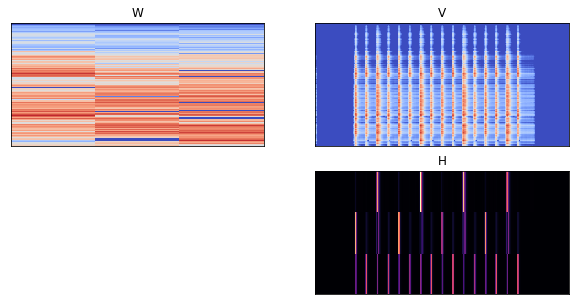

In [7]:
plotNmf(Wd @ Hd, Wd, Hd)

### identify bass drum

In [8]:
# answer here
indice = 2

w=Wd[:,indice]
h=Hd[indice]

h = h.reshape((-1,h.shape[0]))
w = w.reshape((w.shape[0],-1)) 

V = np.matmul(w,h)
                
#####

### predict bass drum magnitude spectral data

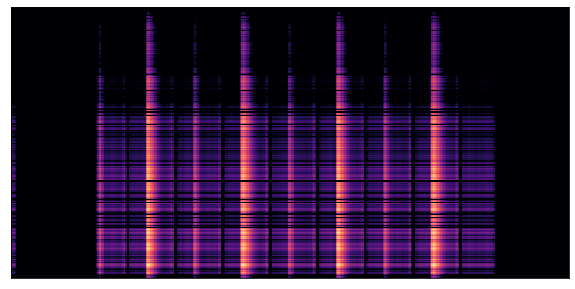

In [9]:
# answer here
BDm = lr.display.specshow(lr.amplitude_to_db(V))
#####

### synthesis

In [10]:
# BDm is the magnitude spectrogram of the Bass Drum
DE = V*np.exp(1j*aD)
de = lr.istft(DE)
ipd.Audio(de, rate=sr)

## Load polyphonic audio

This is a piano performance composed of 3 parts, one is played détaché, one is played arpegiatto, and the other is made of chords.

Describe the performance.

How many tones are played ?

How many pitches are used ?

What should be the minimal order of the NMF to decompose this performance


**Answer**

here

In [11]:
pianoFileName = 'sounds/piano.wav'
p, sr = lr.load(pianoFileName)


limits = [139, 268]

ipd.Audio(p, rate=sr)

## Spectral analysis / synthesis

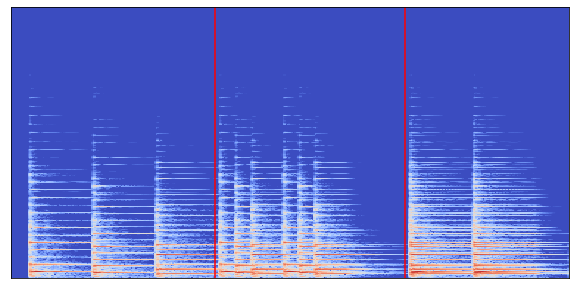

In [12]:
P = lr.stft(p)
mP = np.abs(P)
aP = np.angle(mP)

lr.display.specshow(lr.amplitude_to_db(mP))
plt.plot(np.ones(2)*limits[0], [0, 1024], 'r')
plt.plot(np.ones(2)*limits[1], [0, 1024], 'r')

### Learn on whole, decode whole

perform the nmf decomposition on the whole piano performance.

Interpret the H matrix.

In [13]:
Wp, Hp, err = nmf(mP, 3)

  0%|          | 0/100 [00:00<?, ?it/s]

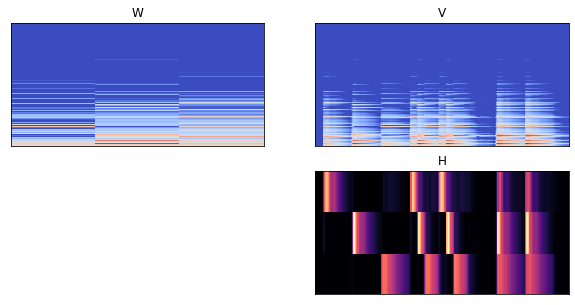

In [14]:
plotNmf(Wp @ Hp, Wp, Hp)

### Learn on "détaché", decode whole

Estimate the dictionnary using only the first part of the performance.

Estimate the activations using this dictionnary for the whole performance.

Is the decomposition of good quality ?

In [15]:
# Answer here
ind_1 = int(limits[0]*p.shape[0]/P.shape[1])
ind_2 = int(limits[1]*p.shape[0]/P.shape[1])

p_1 = p[:ind_1]

ipd.Audio(p_1, rate=sr)
######

In [16]:
P = lr.stft(p_1)
mP_new = np.abs(P)

Wp_new, _, _ = nmf(mP_new, 3)
_, Hp_new, _ = nmf(mP, 3, W=Wp)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

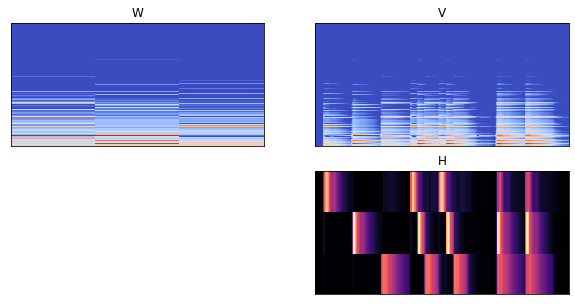

In [17]:
plotNmf(Wp_new @ Hp_new, Wp_new, Hp_new)

### Learn on appregiato, decode whole

Estimate the dictionnary using only the second part of the performance.

Estimate the activations using this dictionnary for the whole performance.

Is the decomposition of good quality ?

In [18]:
# Answer here
p_2 = p[ind_1:ind_2]
ipd.Audio(p_2, rate=sr)
######

In [19]:
P = lr.stft(p_2)
mP_new = np.abs(P)

Wp_new, _, _ = nmf(mP_new, 3)

  0%|          | 0/100 [00:00<?, ?it/s]

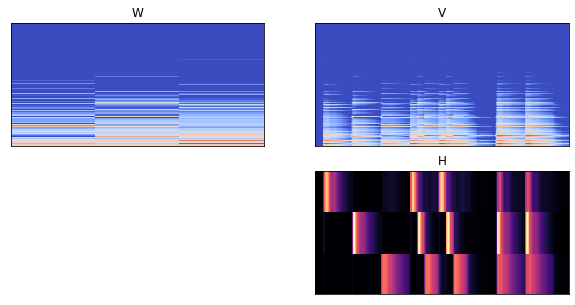

In [20]:
plotNmf(Wp_new @ Hp_new, Wp_new, Hp_new)

### Learn on chords, decode whole

Estimate the dictionnary using only the last part of the performance.

Estimate the activations using this dictionnary for the whole performance.

In [21]:
# Answer here
p_3 = p[ind_2:]
ipd.Audio(p_3, rate=sr)
######

In [22]:
P = lr.stft(p_3)
mP_new = np.abs(P)

Wp_new, _, _ = nmf(mP_new, 3)

  0%|          | 0/100 [00:00<?, ?it/s]

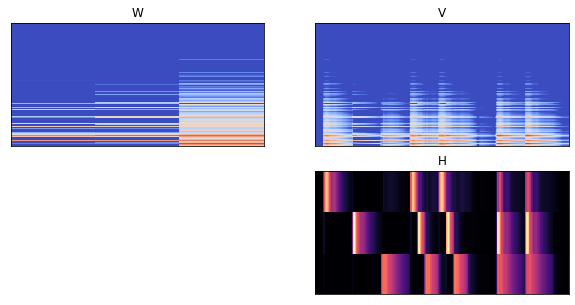

In [23]:
plotNmf(Wp_new @ Hp_new, Wp_new, Hp_new)

**Question**: Is the decomposition of good quality ?

Explain why.

**Answer**: here

## Separating sources from a mix of piano and drums


In [24]:
# mix the piano and the drum
# Answer here
m = p + d
#####
ipd.Audio(m, rate=sr)

## Spectral analysis / synthesis

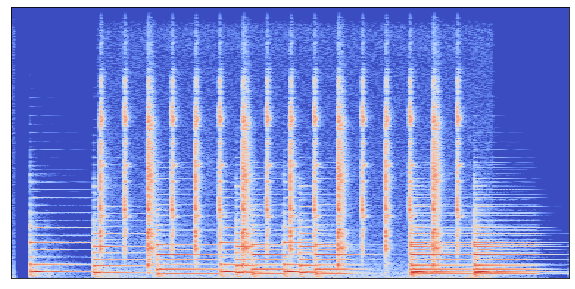

In [25]:
M = lr.stft(m)
mM = np.abs(M)
aM = np.angle(M)

lr.display.specshow(lr.amplitude_to_db(mM))

ME = mM*np.exp(1j*aM)
me = lr.istft(ME)

ipd.Audio(me, rate=sr)

## Consider priors to separate the piano and the drums

build a dictionnary that combines the dictionnaray for the piano source and the drum source. In this case, the selectors are deterministicly determined.

In [26]:
# Answer here
mWp = np.c_[Wp, Wd]
np.random.seed(0)
_, mHp, _ = nmf(mM, 6, W=mWp)
#####

  0%|          | 0/100 [00:00<?, ?it/s]

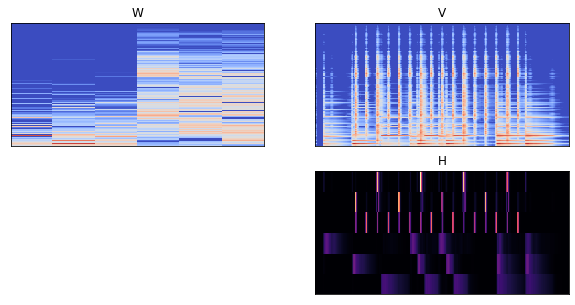

In [27]:
plotNmf(mWp @ mHp, mWp, mHp)

Select the elements of the dictionary that corresponds to the piano to perform the separation

In [28]:
# Answer here
pianoSelector = range(3)
#####

mPM = mWp[:, pianoSelector] @ mHp[pianoSelector, :]
PM = mPM*np.exp(1j*aM)
pm = lr.istft(PM)

ipd.Audio(pm, rate=sr)

Select the elements of the dictionary that corresponds to the drums to perform the separation

In [29]:
# Answer here
drumSelector = [3, 4, 5]
#####

mDM = np.matmul(mWp[:, drumSelector], mHp[drumSelector, :])
DM = mDM*np.exp(1j*aM)
dm = lr.istft(DM)

ipd.Audio(dm, rate=sr)

## Separate the piano and the drums with no priors

perform the nmf with no prior, and manually choose the selectors.

Use those selectors to synthesize the piano and drum source.

  0%|          | 0/100 [00:00<?, ?it/s]

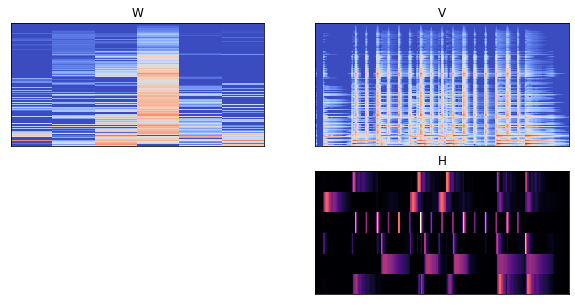

In [30]:
# Answer here
W, H, _ = nmf(mM, 6)
plotNmf(W @ H, W, H)

#####

In [41]:
pianoSelector = [0, 1, 2, 4, 5]
Vp = W[:, pianoSelector] @ H[pianoSelector, :]
P = Vp*np.exp(1j*aM)
p = lr.istft(P)
ipd.Audio(p, rate=sr)

In [42]:
drumSelector = [3]
Vd = W[:, drumSelector] @ H[drumSelector, :]
P = Vd*np.exp(1j*aM)
p = lr.istft(P)
ipd.Audio(p, rate=sr)

In [39]:
selector = 5

w=W[:,selector]
h=H[selector]
h = h.reshape((-1,h.shape[0]))
w = w.reshape((w.shape[0],-1)) 

V = np.matmul(w,h)

DE = V*np.exp(1j*aD)
de = lr.istft(DE)
ipd.Audio(de, rate=sr)

## Bonus

Implement the NMF with the beta divergence.

In [34]:
# Answer here

#####

Test with betas corresponding to the three common divergence (Euclidean, Kullback Leibler, Itakura-Saito). Be sure to start with the same seed for fairness of comparison.

Which divergence, in terms of signal to reconstruction ratio (SRR), is preferable ? 

The SRR is defined as the power of the signal versus the power of the difference between the signal and its estimate.

In [35]:
# Answer here

#####